<a href="https://colab.research.google.com/github/Hyang0219/Dog-Visioner/blob/main/dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Visioner
This is one of the courseworks from Udemy course [Complete Machine Learning and Data Science](https://www.udemy.com/course/complete-machine-learning-and-data-science-zero-to-mastery/).

After following along the tutorial, I decided to start from the scratch.

In this project, we are going to be using **transfer learning** with a pre-trained deep learning model to help us identify different breeds of dogs.

The data is from [Kaggle dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/overview).

We are going to go through below workflow:
1. Load the data from Kaggle competition
2. Preprocess data to turn them into Tensors
3. Choose model from TensorFlow Hub for training
4. Evaluating the model by making predictions and measure the accuracy
5. Improve the model through by customizing layers
6. Train the model on the whole dataset (started with 1000 images and then move to full dataset)

## Data preprocessing

### Data loading

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)
print(hub.__version__)

2.4.1
0.11.0


In [2]:
#import useful libraries and load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

labels = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
#overview of the dataset
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,50d3dfc2c999a9ede891345ae14efd27,scottish_deerhound
freq,1,126


In [4]:
#how manny images for each of the breeds
labels["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

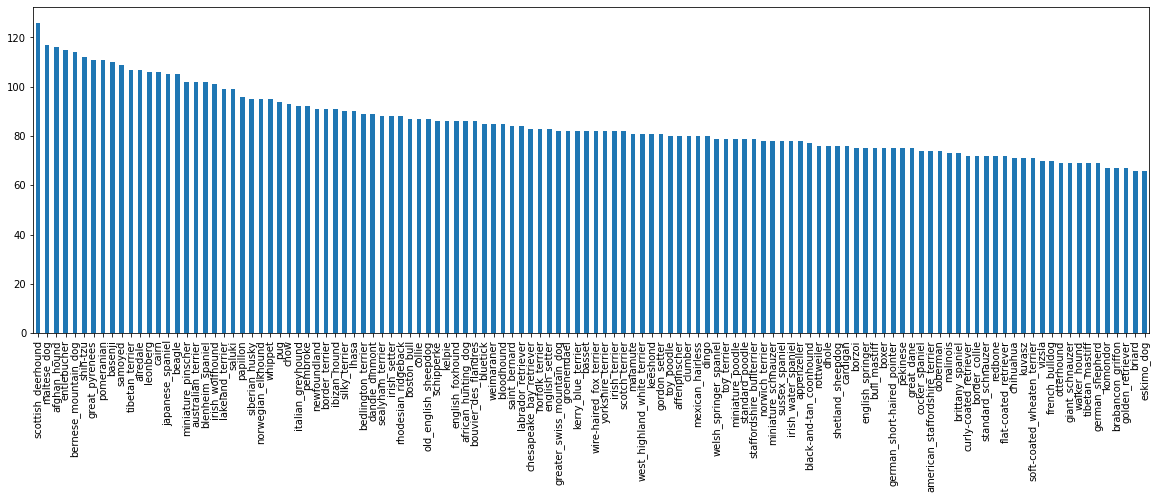

In [5]:
#visualisation
labels["breed"].value_counts().plot(kind="bar", figsize=(20,6));

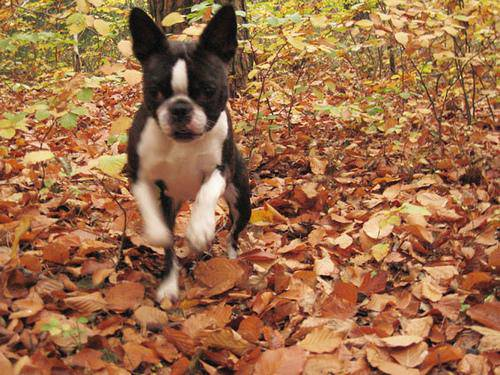

In [6]:
#display one of the image
from IPython.display import Image
Image('drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

### Process images and the labels
We will create:
* A list of filepaths of images
* An array of all labels
* An array of all unique labels

In [7]:
#create filepaths
import os
files = os.listdir("drive/My Drive/Dog Vision/train")
filenames = ["drive/My Drive/Dog Vision/train/" + filenames + ".jpg" for filenames in labels["id"]]
filenames[:5]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

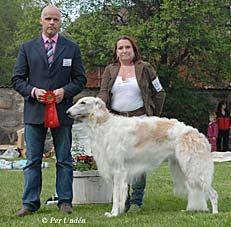

In [8]:
#test an image directly from the filepath we just created
Image(filenames[7])

In [12]:
#create an array of unique labels
unique_labels = np.unique(labels["breed"])
len(unique_labels)

120

In [14]:
#turn one label into an array of booleans
labels["breed"][0] == unique_labels

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
#turn every label into a boolean array
labels_bool = [label == unique_labels for label in labels["breed"]]
labels_bool[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

### Image Processing
#### Create training and validation set

In [16]:
from sklearn.model_selection import train_test_split
import random

In [17]:
#pick the first 1000 images for the first round of training and test to make sure the model works
test_size = 1000
X = filenames[:test_size]
y = labels_bool[:test_size]

#split the data into training and test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 7)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

#### Preprocessing images (turning images into Tensors)

In [19]:
from tensorflow import io
from tensorflow import image

#define image size
image_height = 224
image_width = 224

#create function to take an image file path and turns into a Tensor
def decode_img(file_path, image_size=[image_height, image_width]):
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, image_size)
  return img

#### Creating data batches

In [20]:
#create a function to return a tuple of (image, label)
def process_image(file_path, label_bool):
  image = decode_img(file_path)
  return image, label_bool

(<matplotlib.image.AxesImage at 0x7f18604e19b0>, 'tibetan_terrier')

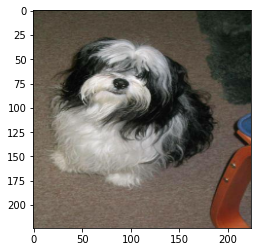

In [23]:
#test the functions
image_test, label_test = process_image(X_train[0], y_train[0])
plt.imshow(image_test.numpy().astype("uint8")), unique_labels[np.argmax(label_test)]

In [24]:
#create training data batches
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), tf.constant(y_train)))
train_ds = train_ds.shuffle(buffer_size=len(X_train))
train_ds_batch = train_ds.map(process_image).batch(batch_size)
len(train_ds_batch)

25

In [25]:
#create validation data batches
val_ds = tf.data.Dataset.from_tensor_slices((tf.constant(X_val), tf.constant(y_val)))
val_ds_batch = val_ds.map(process_image).batch(batch_size)
len(val_ds_batch)

7

In [26]:
#check two batch specs
train_ds_batch.element_spec, val_ds_batch.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

#### Visualizing data batches

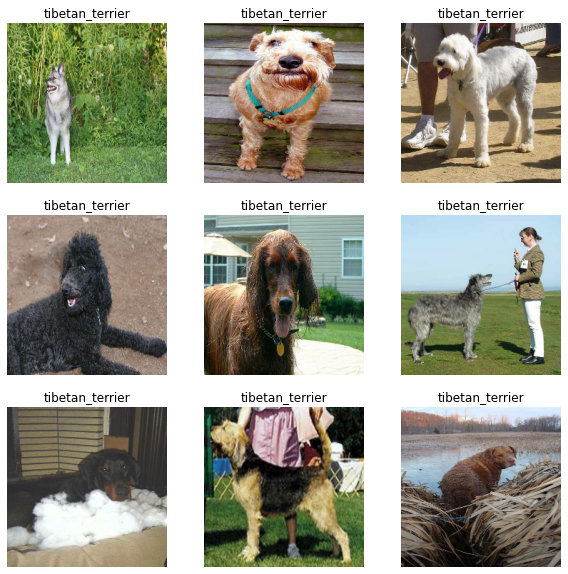

In [27]:
#show images in the first training data batch

plt.figure(figsize=(10,10))

for img, label in train_ds_batch.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(unique_labels[np.argmax(label_test)])
    plt.axis("off")

## Create and Train a model

### Set up parameters of the model

In [28]:
#define image size that fits to the pre-trained model
IMG_SIZE=224

In [29]:
# build machine learning model, parameters need to comply with model requirement
INPUT_SIZE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SIZE = len(unique_labels)
Model_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [30]:
# Images that are represented using floating point values are expected to have values
# in the range [0,1).
rescaling_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [31]:
#create a function that builds the model
def create_model(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE, model_url = Model_URL):

  print(f"Creating model using tensorflow hub model {model_url}")

  model = tf.keras.Sequential([
            rescaling_layer,
            hub.KerasLayer(model_url),
            tf.keras.layers.Dense(output_size, activation="softmax")
  ])

  model.compile(optimizer="adam",
         loss=tf.keras.losses.CategoricalCrossentropy(),
         metrics=["accuracy"])
  
  model.build(input_size) 
  
  return model

#### Build the model

In [32]:
model = create_model(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE, model_url=Model_URL)
model.summary()

Creating model using tensorflow hub model https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


#### Creating callbacks
* EarlyStopping Callback
* TensorBoard Callback

In [33]:
# Create early stopping callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

In [34]:
#load the TensorBoard notebook extension
%load_ext tensorboard

In [35]:
# Create tensorboard callbacks
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [36]:
#set up number of epochs of training
NUM_EPOCHS = 30 #@param {type:"slider", min:0, max:50, step:5}

In [37]:
# Build a function to train and return a trained model
tensorboard = create_tensorboard_callback()

# Fit the model to the data passing it to the callbacks we created
history = model.fit(x=train_ds_batch,
           epochs=NUM_EPOCHS,
           validation_data=val_ds_batch,
           validation_freq=1,
           callbacks=[tensorboard, early_stopping])

Epoch 1/30
25/25 [==============================] - 519s 21s/step - loss: 5.1707 - accuracy: 0.0430 - val_loss: 3.4544 - val_accuracy: 0.2600
Epoch 2/30
25/25 [==============================] - 3s 118ms/step - loss: 1.9379 - accuracy: 0.6189 - val_loss: 2.1569 - val_accuracy: 0.5100
Epoch 3/30
25/25 [==============================] - 3s 122ms/step - loss: 0.6039 - accuracy: 0.9364 - val_loss: 1.7181 - val_accuracy: 0.6200
Epoch 4/30
25/25 [==============================] - 3s 120ms/step - loss: 0.2624 - accuracy: 0.9905 - val_loss: 1.5350 - val_accuracy: 0.6400
Epoch 5/30
25/25 [==============================] - 3s 120ms/step - loss: 0.1543 - accuracy: 0.9994 - val_loss: 1.4529 - val_accuracy: 0.6600
Epoch 6/30
25/25 [==============================] - 3s 121ms/step - loss: 0.0989 - accuracy: 1.0000 - val_loss: 1.4037 - val_accuracy: 0.6500
Epoch 7/30
25/25 [==============================] - 3s 121ms/step - loss: 0.0752 - accuracy: 1.0000 - val_loss: 1.3835 - val_accuracy: 0.6650
Epoch 

#### Evaluate the model on accuracy

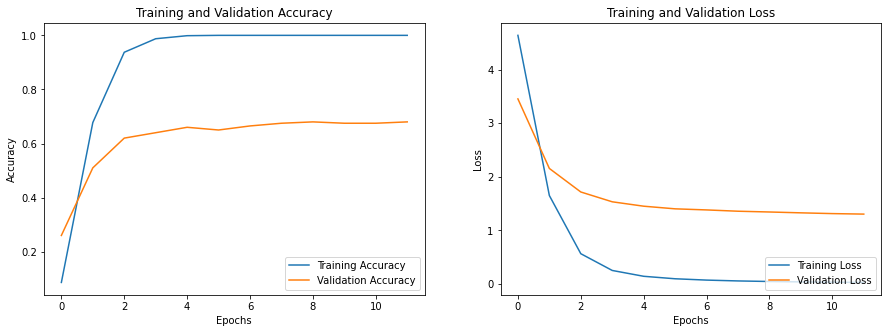

In [38]:
# print accuracy and loss
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.subplot(1,2,2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend(loc="lower right")
plt.ylabel("Loss")
plt.xlabel("Epochs");

The model clearly has overfitting issue and will try to address it using **Data Augmentation** or add **Dropout** or even, just simply fit the model to the whole dataset

#### Address Overfitting with Aata Augmentation

In [39]:
# Clearly a overfitting problem
# Try: data-augmentation

augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2,0.3)
])

In [40]:
#create a function to generate tuned model
def create_tuned_model(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE, model_url = Model_URL):

  print(f"Creating model using tensorflow hub model {model_url}")

  model = tf.keras.Sequential([
            augmentation_layer,
            rescaling_layer,
            hub.KerasLayer(model_url),
            tf.keras.layers.Dense(output_size, activation="softmax")
  ])

  model.compile(optimizer="adam",
         loss=tf.keras.losses.CategoricalCrossentropy(),
         metrics=["accuracy"])
  
  model.build(input_size) 
  
  return model

In [41]:
#overview of the network structure of the tuned model
tuned_model = create_tuned_model(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE, model_url=Model_URL)
tuned_model.summary()

Creating model using tensorflow hub model https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_1 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [42]:
#train the tuned model
tuned_history = tuned_model.fit(train_ds_batch,
                 epochs=NUM_EPOCHS,
                 validation_data=val_ds_batch,
                 callbacks=[early_stopping])

Epoch 1/30
25/25 [==============================] - 7s 144ms/step - loss: 5.7765 - accuracy: 0.0167 - val_loss: 4.1811 - val_accuracy: 0.1000
Epoch 2/30
25/25 [==============================] - 3s 124ms/step - loss: 3.4528 - accuracy: 0.2067 - val_loss: 3.2882 - val_accuracy: 0.1950
Epoch 3/30
25/25 [==============================] - 3s 126ms/step - loss: 2.2250 - accuracy: 0.5030 - val_loss: 2.6896 - val_accuracy: 0.3700
Epoch 4/30
25/25 [==============================] - 3s 125ms/step - loss: 1.4785 - accuracy: 0.6601 - val_loss: 2.3914 - val_accuracy: 0.4400
Epoch 5/30
25/25 [==============================] - 3s 126ms/step - loss: 1.1036 - accuracy: 0.7567 - val_loss: 2.1644 - val_accuracy: 0.4850
Epoch 6/30
25/25 [==============================] - 3s 124ms/step - loss: 0.8949 - accuracy: 0.8095 - val_loss: 2.0283 - val_accuracy: 0.4900
Epoch 7/30
25/25 [==============================] - 3s 126ms/step - loss: 0.6212 - accuracy: 0.8854 - val_loss: 1.9423 - val_accuracy: 0.5100
Epoch 

It does not look like data augmentation has solved the overfitting issue effectively, there is even a reduction on accuracy! we could continue to try adding dropout, however, considering the huge dataset I have on hand, I choose to fit model to the whole dataset and will probably see a substantial improvement on overfitting.

#### Making predictions before moving on training the whole dataset

In [43]:
# Predict use the base model
predictions_probs = model.predict(val_ds_batch)
predictions_probs.shape

(200, 120)

In [44]:
# Create a function return the predicted label
def get_predicted_label(predictions=predictions_probs, n=0):
  return unique_labels[np.argmax(predictions[n])]

In [45]:
# Create a function to process batched data
def process_dataset(dataset, predictions, n=0):
  unbatched_data = dataset.unbatch()
  unbatched_data = list(unbatched_data.as_numpy_iterator())
  image = unbatched_data[n][0]/255
  label = unique_labels[np.argmax(unbatched_data[n][1])]

  confidence = predictions[n][predictions[n].argsort()[::-1][:10]]

  return image, label, confidence

(<matplotlib.image.AxesImage at 0x7f15da8034a8>, 'toy_terrier', 0.2952945)

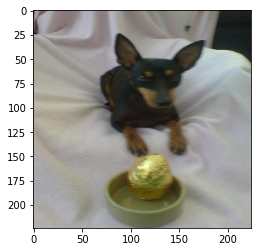

In [46]:
image_test, label_test, confidence_test = process_dataset(val_ds_batch, predictions_probs, 9)
plt.imshow(image_test), label_test, confidence_test[0]

In [47]:
# Create a function to plot the image and print the true and predicted label
def plot_prediction(dataset, predictions, n=0):
  predicted_label = get_predicted_label(predictions, n)
  image, true_label, confidence = process_dataset(dataset, predictions, n)

  top_10_index = predictions[n].argsort()[::-1][:10]
  top_10_values = predictions[n][top_10_index]
  top_10_labels = unique_labels[top_10_index]

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(image)
  if predicted_label == true_label:
    color = "green"
  else:
    color = "red"
  plt.title(predicted_label + " " + f"{confidence[0]*100:.2f}" + "% " + true_label, color=color)
  plt.axis("off")

  plt.subplot(1,2,2)
  top_plot = plt.bar(np.arange(len(top_10_labels)), top_10_values)
  plt.xticks(np.arange(len(top_10_labels)), labels=top_10_labels, rotation="vertical")
  if np.isin(predicted_label,top_10_labels):
    top_plot[np.argmax(predicted_label==top_10_labels)].set_color("green")


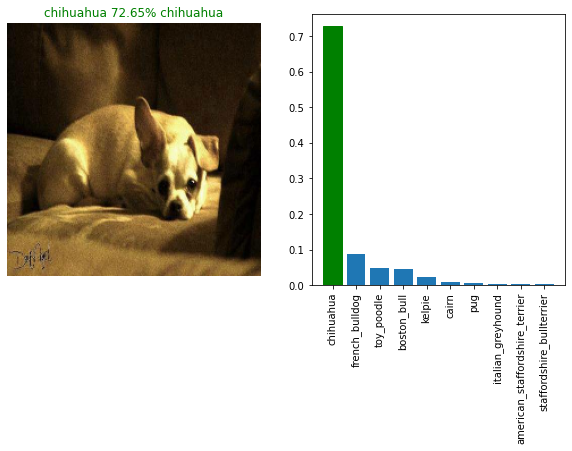

In [48]:
plot_prediction(val_ds_batch, predictions_probs, 199)

## Save and reload the model

In [49]:
#create a function to save the model
def save_model(model, suffix=None):

  # Create model directory with current time
  modeldir = os.path.join("drive/My Drive/Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [50]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

Saving model to: drive/My Drive/Data/models/20210204-20591612472371-1000-images-Adam.h5...


'drive/My Drive/Data/models/20210204-20591612472371-1000-images-Adam.h5'

In [51]:
#create a function to reload the model
def load_model(model_path):
  
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [53]:
#reload the model
model_1000_images = load_model('drive/MyDrive/Data/models/20210204-20591612472371-1000-images-Adam.h5')

Loading saved model from: drive/MyDrive/Data/models/20210204-20591612472371-1000-images-Adam.h5


In [55]:
#quick evaluation between model and reload model to make sure nothing is wrong
model.evaluate(val_ds_batch)

7/7 [==============================] - 1s 78ms/step - loss: 1.3055 - accuracy: 0.6800


[1.3054639101028442, 0.6800000071525574]

In [56]:
model_1000_images.evaluate(val_ds_batch)

7/7 [==============================] - 1s 79ms/step - loss: 1.3055 - accuracy: 0.6800


[1.3054639101028442, 0.6800000071525574]

## Train the model on full dataset

In [60]:
#define full dataset
X_full = filenames
y_full = labels_bool
len(X_full), len(y_full)

(10222, 10222)

In [62]:
#split the data into training and test set
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state = 7)

#create training data batches
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), tf.constant(y_train)))
train_ds = train_ds.shuffle(buffer_size=len(X_train))
train_ds_batch = train_ds.map(process_image).batch(batch_size)

#create validation data batches
val_ds = tf.data.Dataset.from_tensor_slices((tf.constant(X_val), tf.constant(y_val)))
val_ds_batch = val_ds.map(process_image).batch(batch_size)

#check two batch specs
train_ds_batch.element_spec, val_ds_batch.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [63]:
#instantiate a new model for training on the full dataset
full_model = create_model()

Creating model using tensorflow hub model https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [64]:
#create full model callbacks

#tensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

#early stopping callback
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [66]:
#fit the model to the data passing it to the callbacks we created
full_history = full_model.fit(x=train_ds_batch,
           epochs=NUM_EPOCHS,
           validation_data=val_ds_batch,
           validation_freq=1,
           callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/30
256/256 [==============================] - 4903s 19s/step - loss: 2.5944 - accuracy: 0.4461 - val_loss: 0.7188 - val_accuracy: 0.7839
Epoch 2/30
256/256 [==============================] - 30s 116ms/step - loss: 0.3994 - accuracy: 0.8929 - val_loss: 0.6603 - val_accuracy: 0.7936
Epoch 3/30
256/256 [==============================] - 30s 115ms/step - loss: 0.2260 - accuracy: 0.9415 - val_loss: 0.6677 - val_accuracy: 0.7956
Epoch 4/30
256/256 [==============================] - 29s 115ms/step - loss: 0.1448 - accuracy: 0.9671 - val_loss: 0.6708 - val_accuracy: 0.8039
Epoch 5/30
256/256 [==============================] - 30s 115ms/step - loss: 0.0973 - accuracy: 0.9841 - val_loss: 0.6775 - val_accuracy: 0.7902
Epoch 6/30
256/256 [==============================] - 30s 115ms/step - loss: 0.0725 - accuracy: 0.9900 - val_loss: 0.6896 - val_accuracy: 0.7888
Epoch 7/30
256/256 [==============================] - 29s 115ms/step - loss: 0.0526 - accuracy: 0.9944 - val_loss: 0.6961 - val_ac

In [67]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

Saving model to: drive/My Drive/Data/models/20210204-22451612478720-all-images-Adam.h5...


'drive/My Drive/Data/models/20210204-22451612478720-all-images-Adam.h5'

We can see a validation accuracy bumped up from 68% to 79% by training on the full dataset, but still a long way to go to be qualified a good classifier.

Further work to improve the model:
1. Reduce overfitting by data augmentation and dropout on the full dataset
2. Fine-tuning the pre-trained model to switch a few more top layers to trainable so we can create a more suitable model for telling breeds of dogs.
3. Try a differenent model, potentially a more sophisticated one; mobilenet was used here for its fairly simple CNN architecture, comparing to the others.